# The Stingray Modeling API Explained

Some more in-depth explanations of how the Stingray modeling API works.

Who should be using this API?
Basically, anyone who wants to model power spectral products with parametric functions. The purpose of this API is two-fold:
(1) provide convenient methods and classes in order to model a large range of typical data representations implemented in Stingray
(2) provide a more general framework for users to build their own models

A note on terminology: in this tutorial, we largely use _model_ to denote both the parametric model describing the underlying process that generated the data, and the statistical model used to account for uncertainties in the measurement process. 

The `modeling` subpackage defines a wider range of classes for typical statistical models than most standard modelling packages in X-ray astronomy, including likelihoods for Gaussian-distributed uncertainties (what astronomers call the $\chi^2$ likelihood), Poisson-distributed data (e.g. light curves) and $\chi^2$-distributed data (confusingly, *not* what astronomers call the $\chi^2$ likelihood, but the likelihood of data with $\chi^2$-distributed uncertainties appropriate for power spectra). It also defines a superclass `LogLikelihood` that make extending the framework to other types of data uncertainties straightforward. It supports Bayesian modelling via the `Posterior` class and its subclasses (for different types of data, equivalent to the likelihood classes) and provides support for defining priors. 

The class `ParameterEstimation` and its data type-specific subclasses implement a range of operations usually done with power spectra and other products, including optimization (fitting), sampling (via Markov-Chain Monte Carlo), calibrating models comparison metrics (particularly likelihood ratio tests) and outlier statistics (for finding periodic signal candidates).

Overall, it is designed to be as modular as possible and extensible to new data types and problems in many places, though we do explicitly *not* aim to provide a fully general modelling framework (for example, at the moment, we have given no thought to modeling multi-variate data, though this may change in the future).


## Some background

Modeling power spectra and light curves with parametric models is a fairly standard task. Stingray aims to make solving these problems as easy as possible. 

We aim to integrate our existing code with `astropy.modeling` for for maximum compatibility. Please note, however, that we are only using the models, not the fitting interface, which is too constrained for our purposes. 


In [2]:
%load_ext autoreload
%autoreload 2
# ignore warnings to make notebook easier to see online
# COMMENT OUT THESE LINES FOR ACTUAL ANALYSIS
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_palette("colorblind")
except ImportError:
    print("Install seaborn. It help you make prettier figures!")

import numpy as np

from astropy.modeling import models

The models and API of `astropy.modeling.models` is explained in the [astropy documentation](http://docs.astropy.org/en/stable/modeling/) in more detail.

Here's how you instantiate a simple 1-D Gaussian:

In [4]:
g = models.Gaussian1D()

<ErrorbarContainer object of 3 artists>

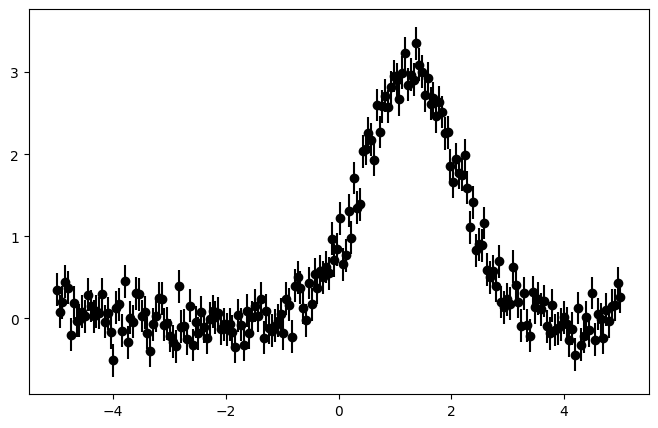

In [5]:
# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
yerr = 0.2

plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=yerr, fmt='ko')


## Likelihoods and Posteriors

In general, model fitting will happen either in a frequentist (Maximum Likelihood) or Bayesian framework. Stingray's strategy is to let the user define a posterior in both cases, but ignore the prior in the former case. 

Let's first make some fake data:

In [6]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

We're going to pick some fairly standard parameters for our data:

In [7]:
# parameters for fake data.
alpha = 2.0
amplitude = 5.0
white_noise = 2.0

And now a frequency array:

In [8]:
freq = np.linspace(0.01, 10.0, int(10.0/0.01))

Now we can set the parameters in the model:

In [9]:
from astropy.modeling.fitting import fitter_to_model_params

fitter_to_model_params(plc, [amplitude, alpha, white_noise])


In [10]:
psd_shape = plc(freq)

As a last step, we need to add noise by picking from a chi-square distribution with 2 degrees of freedom:

In [11]:
powers = psd_shape*np.random.chisquare(2, size=psd_shape.shape[0])/2.0

Let's plot the result:

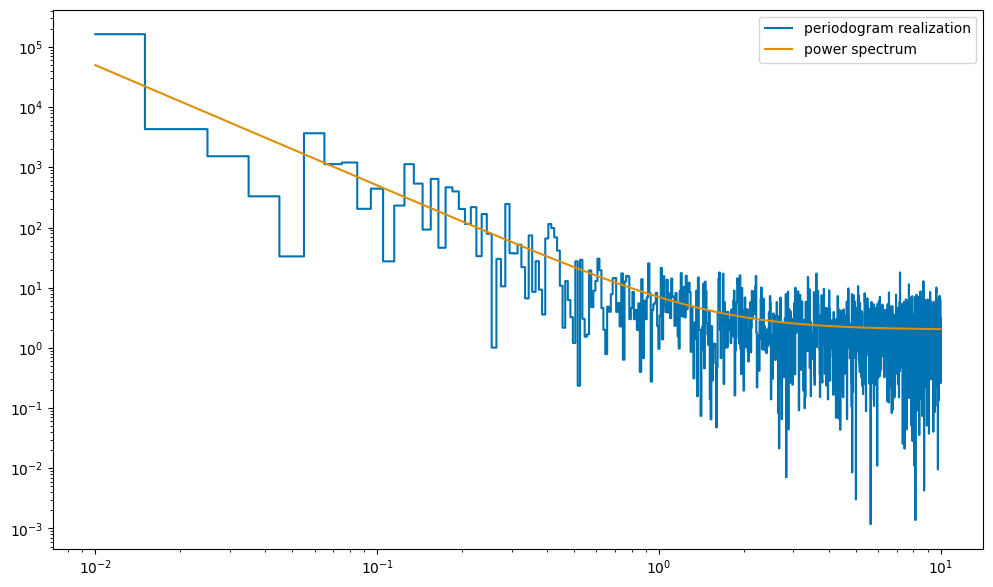

In [12]:
plt.figure(figsize=(12,7))
plt.loglog(freq, powers, ds="steps-mid", label="periodogram realization")
plt.loglog(freq, psd_shape, label="power spectrum")


plt.legend()

## Maximum Likelihood Fitting

Let's assume we've observed this periodogram from our source. We would now like to estimate the parameters. 
This requires the definition of *likelihood*, which describes the probability of observing the data plotted above given some underlying model with a specific set of parameters. To say it differently, the likelihood encodes what we know about the underlying model (here a power law and a constant) and the statistical properties of the data (power spectra generally follow a chi-square distribution) and then allows us to compare data and model for various parameters under the assumption of the statistical uncertainties.

In order to find the best parameter set, one generally maximizes the likelihood function using an optimization algorithm. Because optimization algorithms generally *minimize* functions, they effectively minimize the log-likelihood, which comes out to be the same as maximizing the likelihood itself.

Below is an implementation of the $\chi^2$ likelihood as appropriate for power spectral analysis, with comments for easier understanding. The same is also implemented in `posterior.py` in Stingray:

In [13]:
logmin = -1e16
class PSDLogLikelihood(object):

    def __init__(self, freq, power, model, m=1):
        """
        A Chi-square likelihood as appropriate for power spectral analysis.

        Parameters
        ----------
        freq : iterable
            x-coordinate of the data

        power : iterable
            y-coordinte of the data

        model: an Astropy Model instance
            The model to use in the likelihood.

        m : int
            1/2 of the degrees of freedom, i.e. the number of powers
            that were averaged to obtain the power spectrum input into
            this routine.

        """

        self.x = ps.freq # the x-coordinate of the data (frequency array)
        self.y = ps.power # the y-coordinate of the data (powers)
        self.model = model # an astropy.models instance
        self.m = m

        self.params = [k for k,l in self.model.fixed.items() if not l]
        self.npar = len(self.params) # number of free parameters

    def evaluate(self, pars, neg=False):
        """
        Evaluate the log-likelihood.

        Parameters
        ----------
        pars : iterable
            The list of parameters for which to evaluate the model.

        neg : bool, default False
            If True, compute the *negative* log-likelihood, otherwise
            compute the *positive* log-likelihood.

        Returns
        -------
        loglike : float
            The log-likelihood of the model

        """
        # raise an error if the length of the parameter array input into
        # this method doesn't match the number of free parameters in the model
        if np.size(pars) != self.npar:
            raise Exception("Input parameters must" +
                            " match model parameters!")

        # set parameters in self.model to the parameter set to be used for
        # evaluation
        fitter_to_model_params(self.model, pars)

        # compute the values of the model at the positions self.x
        mean_model = self.model(self.x)

        # if the power spectrum isn't averaged, compute simple exponential
        # likelihood (chi-square likelihood for 2 degrees of freedom)
        if self.m == 1:
            loglike = -np.sum(np.log(mean_model)) - \
                      np.sum(self.y/mean_model)
        # otherwise use chi-square distribution to compute likelihood
        else:
            loglike = -2.0*self.m*(np.sum(np.log(mean_model)) +
                               np.sum(self.y/mean_model) +
                               np.sum((2.0 / (2. * self.m) - 1.0) *
                                      np.log(self.y)))

        if not np.isfinite(loglike):
            loglike = logmin

        if neg:
            return -loglike
        else:
            return loglike

    def __call__(self, parameters, neg=False):
        return self.evaluate(parameters, neg)


Let's make an object and see what it calculates if we put in different parameter sets. First, we have to make our sample PSD into an actual `Powerspectrum` object:

In [14]:
from stingray import Powerspectrum

ps = Powerspectrum()
ps.freq = freq
ps.power = powers
ps.df = ps.freq[1] - ps.freq[0]
ps.m = 1

In [15]:
loglike = PSDLogLikelihood(ps.freq, ps.power, plc, m=ps.m)

In [16]:
test_pars = [1, 5, 100]
loglike(test_pars)

-4835.88214847462

In [17]:
test_pars = [4.0, 10, 2.5]
loglike(test_pars)

-2869.5582486265116

In [18]:
test_pars = [2.0, 5.0, 2.0]
loglike(test_pars)

-2375.704120812954

Something close to the parameters we put in should yield the largest log-likelihood. Feel free to play around with the test parameters to verify that this is true.

You can similarly import the `PSDLogLikelihood` class from `stingray.modeling` and do the same:



In [19]:
from stingray.modeling import PSDLogLikelihood

loglike = PSDLogLikelihood(ps.freq, ps.power, plc, m=ps.m)
loglike(test_pars)

-2375.704120812954

To estimate the parameters, we can use an optimization routine, such as those implemented in `scipy.optimize.minimize`.
We have wrapped some code around that, to make your lives easier. We will not reproduce the full code here, just demonstrate its functionality.

Now we can instantiate the `PSDParEst` (for PSD Parameter Estimation) object. This can do more than simply optimize a single model, but we'll get to that later.

The `PSDParEst` object allows one to specify the fit method to use (however, this must be one of the optimizers in `scipy.optimize`). The parameter `max_post` allows for doing maximum-a-posteriori fits on the Bayesian posterior rather than maximum likelihood fits (see below for more details). We'll set it to `False` for now, since we haven't defined any priors:

In [20]:
from stingray.modeling import PSDParEst

parest = PSDParEst(ps, fitmethod="L-BFGS-B", max_post=False)

In order to fit a model, make an instance of the appropriate `LogLikelihood` or `Posterior` subclass, andsimply call the `fit` method with that instance and starting parameters you would like to fit.

In [21]:
loglike = PSDLogLikelihood(ps.freq, ps.power, plc, m=ps.m)

In [21]:
loglike.model.parameters

array([2., 1., 5., 2.])

In [22]:
loglike.npar

3

In [23]:
starting_pars = [3.0, 1.0, 2.4]
res = parest.fit(loglike, starting_pars)

The result is an `OptimizationResults` object, which computes various summaries and useful quantities.

For example, here's the value of the likelihood function at the maximum the optimizer found:

In [24]:
res.result

2183.7896770363714

**Note**: Optimizers routinely get stuck in *local* minima (corresponding to local maxima of the likelihood function). It is usually useful to run an optimizer several times with different starting parameters in order to get close to the global maximum.

Most useful are the estimates of the parameters at the maximum likelihood and their uncertainties:

In [25]:
print(res.p_opt)
print(res.err)

[4.72914375 2.09193245 2.10372405]
[3.81602879 0.73153211 0.55746655]


**Note**: uncertainties are estimated here via the covariance matrix between parameters, i.e. the inverse of the Hessian at the maximum. This only represents the true uncertainties for specific assumptions about the likelihood function (Gaussianity), so use with care!

It also computes Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) for model comparison purposes:

In [26]:
print("AIC: " + str(res.aic))
print("BIC: " + str(res.bic))

AIC: 2189.7896770363714
BIC: 2204.5129428733176


Finally, it also produces the values of the mean function for the parameters at the maximum. Let's plot that and compare with the power spectrum we put in:

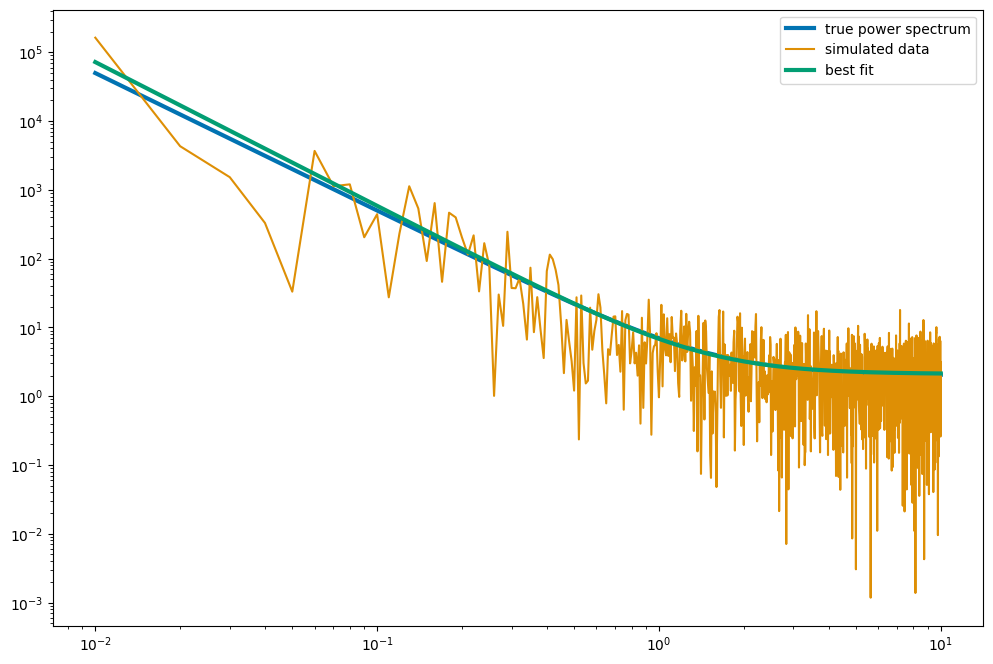

In [27]:
plt.figure(figsize=(12,8))
plt.loglog(ps.freq, psd_shape, label="true power spectrum",lw=3)
plt.loglog(ps.freq, ps.power, label="simulated data")
plt.loglog(ps.freq, res.mfit, label="best fit", lw=3)
plt.legend()

That looks pretty good!

You can print a summary of the fitting results by calling `print_summary`:

In [28]:
res.print_summary(loglike)

2025-02-27 01:05:08,634 - Fitting summary - INFO - The best-fit model parameters plus errors are: (parameterestimation.py:278)
2025-02-27 01:05:08,635 - Fitting summary - INFO -   0) Parameter amplitude_0         :  (parameterestimation.py:288)
2025-02-27 01:05:08,641 - Fitting summary - INFO - 4.72914              +/- 3.81603               (parameterestimation.py:296)
2025-02-27 01:05:08,642 - Fitting summary - INFO - [      None       None] (parameterestimation.py:297)
2025-02-27 01:05:08,645 - Fitting summary - INFO -   1) Parameter x_0_0               :  (parameterestimation.py:288)
2025-02-27 01:05:08,646 - Fitting summary - INFO - 1.00000              (Fixed)  (parameterestimation.py:299)
2025-02-27 01:05:08,647 - Fitting summary - INFO -   2) Parameter alpha_0             :  (parameterestimation.py:288)
2025-02-27 01:05:08,649 - Fitting summary - INFO - 2.09193              +/- 0.73153               (parameterestimation.py:296)
2025-02-27 01:05:08,650 - Fitting summary - INFO - 

### Likelihood Ratios

The parameter estimation code has more functionality than act as a simple wrapper around `scipy.optimize`. For example, it allows for easy computation of likelihood ratios. Likelihood ratios are a standard way to perform comparisons between two models (though they are not always statistically meaningful, and should be used with caution!).

To demonstrate that, let's make a broken power law model

In [29]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
bplc = bpl + c

In [30]:
bplc.param_names

('amplitude_0', 'x_break_0', 'alpha_1_0', 'alpha_2_0', 'amplitude_1')

In [31]:
# define starting parameters
bplc_start_pars = [2.0, 1.0, 3.0, 1.0, 2.5]

In [32]:
loglike_bplc = PSDLogLikelihood(ps.freq, ps.power, bplc, m=ps.m)

In [33]:
pval, plc_opt, bplc_opt = parest.compute_lrt(loglike, starting_pars, loglike_bplc, bplc_start_pars)

In [34]:
print("Likelihood Ratio: " + str(pval))

Likelihood Ratio: 2.2374415016683997



## Bayesian Parameter Estimation

For Bayesian parameter estimation, we require a prior along with the likelihood defined above. Together, they form the *posterior*, the probability of the parameters given the data, which is what we generally want to compute in science.

Since there are no universally accepted priors for a model (they depend on the problem at hand and your physical knowledge about the system), they cannot be easily hard-coded in stingray. Consequently, setting priors is slightly more complex. 

Analogously to the `LogLikelihood` above, we can also define a `Posterior` object. Each posterior object has three methods: `logprior`, `loglikelihood` and `logposterior`. 

We have pre-defined some `Posterior` objects in `posterior.py` for common problems, including power spectral analysis. We start by making a `PSDPosterior` object:

In [35]:
from stingray.modeling import PSDPosterior

In [36]:
lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)

The priors are set as a dictionary of functions:

In [37]:
import scipy.stats

# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((0.01 <= amplitude) & (amplitude <= 10.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise


There's a function `set_logprior` in `stingray.modeling` that sets the prior correctly:

In [38]:
from stingray.modeling import set_logprior

In [39]:
lpost.logprior = set_logprior(lpost, priors)

You can also set the priors when you instantiate the posterior object:

In [40]:
lpost = PSDPosterior(ps.freq, ps.power, plc, priors=priors, m=ps.m)

Much like before with the log-likelihood, we can now also compute the log-posterior for various test parameter sets:

In [41]:
test_pars = [1.0, 2.0, 4.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: -198.61635344021062
log-likelihood: -2412.2493594640564
log-posterior: -2610.865712904267


When the prior is zero (so the log-prior is -infinity), it automatically gets set to a very small value in order to avoid problems when doing the optimization:

In [42]:
test_pars = [6, 6, 3.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: -1e+16
log-likelihood: -2534.0567826161864
log-posterior: -1e+16


In [43]:
test_pars = [5.0, 2.0, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

log-prior: 1.383646559789373
log-likelihood: -2184.6739536386162
log-posterior: -2183.290307078827


We can do the same parameter estimation as above, except now it's called maximum-a-posteriori instead of maximum likelihood and includes the prior (notice we set `max_post=True`):

In [44]:
parest = PSDParEst(ps, fitmethod='BFGS', max_post=True)
res = parest.fit(lpost, starting_pars)

In [45]:
print("best-fit parameters:")
for p,e in zip(res.p_opt, res.err):
    print("%.4f +/- %.4f"%(p,e))

best-fit parameters:
4.8949 +/- 0.3560
2.0690 +/- 0.0279
2.0547 +/- 0.0401


The same outputs exist as for the Maximum Likelihood case:

In [46]:
res.print_summary(lpost)

2025-02-27 01:05:37,023 - Fitting summary - INFO - The best-fit model parameters plus errors are: (parameterestimation.py:278)
2025-02-27 01:05:37,025 - Fitting summary - INFO -   0) Parameter amplitude_0         :  (parameterestimation.py:288)
2025-02-27 01:05:37,028 - Fitting summary - INFO - 4.89491              +/- 0.35596               (parameterestimation.py:296)
2025-02-27 01:05:37,029 - Fitting summary - INFO - [      None       None] (parameterestimation.py:297)
2025-02-27 01:05:37,031 - Fitting summary - INFO -   1) Parameter x_0_0               :  (parameterestimation.py:288)
2025-02-27 01:05:37,033 - Fitting summary - INFO - 1.00000              (Fixed)  (parameterestimation.py:299)
2025-02-27 01:05:37,034 - Fitting summary - INFO -   2) Parameter alpha_0             :  (parameterestimation.py:288)
2025-02-27 01:05:37,036 - Fitting summary - INFO - 2.06898              +/- 0.02793               (parameterestimation.py:296)
2025-02-27 01:05:37,038 - Fitting summary - INFO - 

Unlike in the maximum likelihood case, we can also *sample* from the posterior probability distribution. The method `sample` uses the [emcee](http://emcee.readthedocs.io/) package to do MCMC. 

**Important**: Do *not* sample from the likelihood function. This is formally incorrect and can lead to incorrect inferences about the problem, because there is no guarantee that a posterior with improper (flat, infinite) priors will be bounded!

**Important**: emcee has had a major upgrade to version 3, which came with a number of API changes. To ensure compatibility with stingray, please update emcee to the latest version, if you haven't already.

Much like the optimizer, the sampling method requires a model and a set of starting parameters `t0`. Optionally, it can be useful to also input a covariance matrix, for example from the output of the optimizer.

Finally, the user should specify the number of walkers as well as the number of steps to use for both burn-in and sampling:


In [47]:
sample = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=400,
             niter=100, burnin=300, namestr="psd_modeling_test")


Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.642000.5
R_hat for the parameters is: [0.34325401 0.00749    0.00471878]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 4.965428322258819	0.5865842468406106	4.038113935080179	5.9662519427965695

theta[1] 	 2.074793652235716	0.08665171496634255	1.9380138454324662	2.222971708920736

theta[2] 	 2.056289218531818	0.0687789049471551	1.9449801310443702	2.1722698817713124



The sampling method returns an object with various attributes that are useful for further analysis, for example the acceptance fraction:

In [48]:
sample.acceptance

0.642

Or the mean and confidence intervals of the parameters:

In [49]:
sample.mean

array([4.96542832, 2.07479365, 2.05628922])

In [50]:
sample.ci

array([[4.03811394, 1.93801385, 1.94498013],
       [5.96625194, 2.22297171, 2.17226988]])

The method `print_results` prints the results:

In [51]:
sample.print_results()

-- The acceptance fraction is: 0.642000.5
R_hat for the parameters is: [0.34325401 0.00749    0.00471878]
-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

theta[0] 	 4.965428322258819	0.5865842468406106	4.038113935080179	5.9662519427965695

theta[1] 	 2.074793652235716	0.08665171496634255	1.9380138454324662	2.222971708920736

theta[2] 	 2.056289218531818	0.0687789049471551	1.9449801310443702	2.1722698817713124



Similarly, the method `plot_results` produces a bunch of plots:

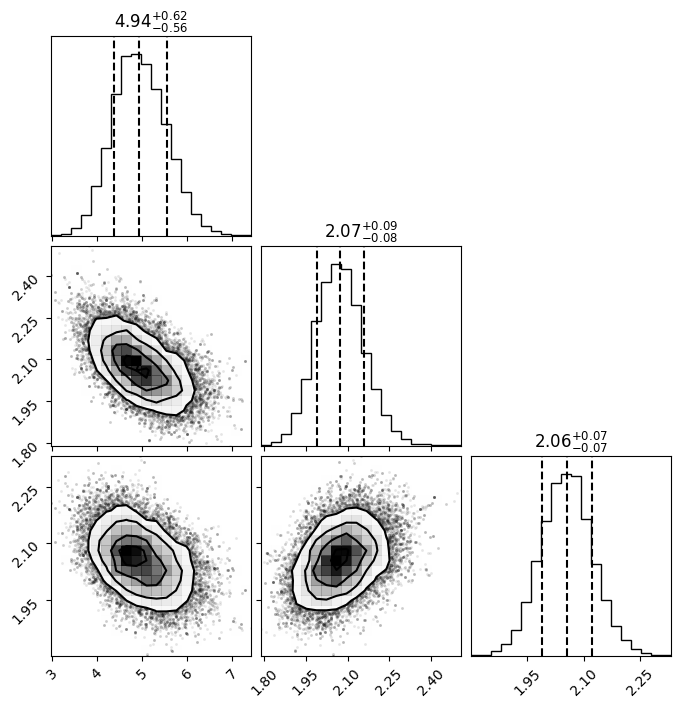

In [52]:
fig = sample.plot_results(nsamples=1000, fig=None, save_plot=True,
                    filename="modeling_tutorial_mcmc_corner.pdf")

## Calibrating Likelihood Ratio Tests

In order to use likelihood ratio tests for model comparison, one must compute the p-value of obtaining a likelihood ratio at least as high as that observed given that the null hypothesis (the simpler model) is true. The distribution of likelihood ratios under that assumption will only follow an analytical distribution if
* the models are nested, i.e. the simpler model is a special case of the more complex model *and*
* the parameter values that transform the complex model into the simple one do not lie on the boundary of parameter space. 

Imagine e.g. a simple model without a QPO, and a complex model with a QPO, where in order to make the simpler model out of the more complex one you would set the QPO amplitude to zero. However, the amplitude cannot go below zero, thus the critical parameter value transforming the complex into the simple model lie on the boundary of parameter space.

If these two conditions are not given, the observed likelihood ratio must be calibrated via simulations of the simpler model. In general, one should *not* simulate from the best-fit model alone: this ignores the uncertainty in the model parameters, and thus may artificially inflate the significance of the result.

In the purely frequentist (maximum likelihood case), one does not know the shape of the probability distribution for the parameters. A rough approximation can be obtained by assuming the likelihood surface to be a multi-variate Gaussian, with covariances given by the inverse Fisher information. One may sample from that distribution and then simulate fake data sets using the sampled parameters. Each simulated data set will be fit with both models to compute a likelihood ratio, which is then used to build a distribution of likelihood ratios from the simpler model to compare the observed likelihood ratio to.

In the Bayesian case, one may sample from the posterior for the parameters directly and then use these samples as above to create fake data sets in order to derive a posterior probability distribution for the likelihood ratios and thus a posterior predictive p-value.

For the statistical background of much of this, see [Protassov et al, 2002](http://adsabs.harvard.edu/abs/2002ApJ...571..545P).

Below, we set up code that will do exactly that, for both the frequentist and Bayesian case.


In [53]:
import copy

def _generate_model(lpost, pars):
    """
    Helper function that generates a fake PSD similar to the
    one in the data, but with different parameters.

    Parameters
    ----------
    lpost : instance of a Posterior or LogLikelihood subclass
        The object containing the relevant information about the
        data and the model

    pars : iterable
        A list of parameters to be passed to lpost.model in oder
        to generate a model data set.

    Returns:
    --------
    model_data : numpy.ndarray
        An array of model values for each bin in lpost.x

    """
    # get the model
    m = lpost.model

    # reset the parameters
    fitter_to_model_params(m, pars)

    # make a model spectrum
    model_data = lpost.model(lpost.x)

    return model_data

def _generate_psd(ps, lpost, pars):
    """
    Generate a fake power spectrum from a model.

    Parameters:
    ----------
    lpost : instance of a Posterior or LogLikelihood subclass
        The object containing the relevant information about the
        data and the model

    pars : iterable
        A list of parameters to be passed to lpost.model in oder
        to generate a model data set.

    Returns:
    --------
    sim_ps : stingray.Powerspectrum object
        The simulated Powerspectrum object

    """

    model_spectrum = _generate_model(lpost, pars)

      # use chi-square distribution to get fake data
    model_powers = model_spectrum*np.random.chisquare(2*ps.m,
                                                      size=model_spectrum.shape[0])/(2.*ps.m)

    sim_ps = copy.copy(ps)

    sim_ps.powers = model_powers


    return sim_ps

def _compute_pvalue(obs_val, sim):
    """
    Compute the p-value given an observed value of a test statistic
    and some simulations of that same test statistic.

    Parameters
    ----------
    obs_value : float
        The observed value of the test statistic in question

    sim: iterable
        A list or array of simulated values for the test statistic

    Returns
    -------
    pval : float [0, 1]
        The p-value for the test statistic given the simulations.

    """

    # cast the simulations as a numpy array
    sim = np.array(sim)

    # find all simulations that are larger than
    # the observed value
    ntail = sim[sim > obs_val].shape[0]

    # divide by the total number of simulations
    pval = ntail/sim.shape[0]

    return pval

def calibrate_lrt(ps, lpost1, t1, lpost2, t2, sample=None, neg=True, max_post=False,
                  nsim=1000, niter=200, nwalker=500, burnin=200, namestr="test"):


    # set up the ParameterEstimation object
    parest = PSDParEst(ps, fitmethod="L-BFGS-B", max_post=False)

    # compute the observed likelihood ratio
    lrt_obs, res1, res2 = parest.compute_lrt(lpost1, t1,
                                             lpost2, t2,
                                             neg=neg,
                                             max_post=max_post)

    # simulate parameter sets from the simpler model
    if not max_post:
        # using Maximum Likelihood, so I'm going to simulate parameters
        # from a multivariate Gaussian

        # set up the distribution
        mvn = scipy.stats.multivariate_normal(mean=res1.p_opt, cov=res1.cov)

        # sample parameters
        s_all = mvn.rvs(size=nsim)

    else:
        if sample is None:
            # sample the posterior using MCMC
            sample = parest.sample(lpost, res1.p_opt, cov=res1.cov,
                                   nwalkers=nwalker, niter=niter,
                                   burnin=burnin, namestr=namestr)


        # pick nsim samples out of the posterior sample
        s_all = sample[np.random.choice(sample.shape[0], nsim, replace=False)]

    lrt_sim = np.zeros(nsim)

    # now I can loop over all simulated parameter sets to generate a PSD
    for i,s in enumerate(s_all):

        # generate fake PSD
        sim_ps = _generate_psd(ps, lpost1, s)

        # make LogLikelihood objects for both:
        if not max_post:
            sim_lpost1 = PSDLogLikelihood(sim_ps.freq, sim_ps.power,
                                         model=lpost1.model, m=sim_ps.m)
            sim_lpost2 = PSDLogLikelihood(sim_ps.freq, sim_ps.power,
                                         model=lpost2.model, m=sim_ps.m)
        else:
            # make a Posterior object
            sim_lpost1 = PSDPosterior(sim_ps.freq, sim_ps.power,
                                      lpost1.model, m=sim_ps.m)
            sim_lpost1.logprior = lpost1.logprior

            sim_lpost2 = PSDPosterior(sim_ps.freq, sim_ps.power,
                                      lpost2.model, m=sim_ps.m)
            sim_lpost2.logprior = lpost2.logprior


        parest_sim = PSDParEst(sim_ps, max_post=max_post)

        lrt_sim[i], _, _ = parest_sim.compute_lrt(sim_lpost1, t1,
                                         sim_lpost2, t2,
                                         neg=neg,
                                         max_post=max_post)

    # now I can compute the p-value:
    pval = _compute_pvalue(lrt_obs, lrt_sim)
    return pval

In [54]:
pval = calibrate_lrt(ps, loglike, starting_pars,
                     loglike_bplc, bplc_start_pars,
                     max_post=False, nsim=100)

In [55]:
print("The p-value for rejecting the simpler model is: " + str(pval))

The p-value for rejecting the simpler model is: 0.86


As expected, the p-value for rejecting the powerlaw model is fairly large: since we simulated from that model, we would be surprised if it generated a small p-value, causing us to reject this model (note, however, that if the null hypothesis is true, the p-value will be uniformely distributed between 0 and 1. By definition, then, you will get a p-value smaller or equal to 0.01 in approximately one out of a hundred cases)

We can do the same with the Bayesian model, in which case the result is called a *posterior predictive p-value*, which, in turn, is often used in posterior model checking (not yet implemented!).

We have not yet defined a `PSDPosterior` object for the bent power law model, so let's do that. First, let's define some priors:

In [56]:
import scipy.stats

# flat prior for the power law indices
p_alpha1 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))
p_alpha2 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the break frequency
p_x_break = lambda xbreak: ((0.01 <= xbreak) & (10.0 >= xbreak))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((0.01 <= amplitude) & (amplitude <= 10.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_1_0"] = p_alpha
priors["alpha_2_0"] = p_alpha

priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise
priors["x_break_0"] = p_x_break


Now we can set up the `PSDPosterior` object:

In [57]:
lpost_bplc = PSDPosterior(ps.freq, ps.power, bplc, priors=priors, m=ps.m)

In [58]:
lpost_bplc(bplc_start_pars)

-2230.14039643262

And do the posterior predictive p-value. Since we've already sampled from the simple model, we can pass that sample to the `calibrate_lrt` function, in order to cut down on computation time (if the keyword `sample` is not given, it will automatically run MCMC:

In [59]:
pval = calibrate_lrt(ps, lpost, starting_pars,
                     lpost_bplc, bplc_start_pars,
                     sample=sample.samples,
                     max_post=True, nsim=100)

In [60]:
print("The posterior predictive p-value is: p = " + str(pval))

The posterior predictive p-value is: p = 0.81


Again, we find that the p-value does not suggest rejecting the powerlaw model.

Of course, a slightly modified version is implemented in `stingray` as a subclass of the `PSDParEst` class:

In [61]:
from stingray.modeling import PSDParEst

In [62]:
parest = PSDParEst(ps, fitmethod="BFGS")

In [63]:
pval = parest.calibrate_lrt(lpost, starting_pars, lpost_bplc, bplc_start_pars,
                   sample=sample.samples, nsim=100, max_post=True, seed=200)

In [64]:
print(pval)

0.18


## Bayesian-ish QPO Searches

When searching for quasi-periodic oscillations (QPOs) in light curves that are not constant (for example because they are bursts or have other types of variability), one must take care that the variable background is accurately modelled (most standard tools assume that the light curve is constant). 

In [Vaughan et al, 2010](http://adsabs.harvard.edu/abs/2010MNRAS.402..307V), a method was introduced to search for QPOs in the presence of red noise (stochastic variability), and in [Huppenkothen et al, 2013](http://adsabs.harvard.edu/abs/2013ApJ...768...87H) it was extended to magnetar bursts, and in [Inglis et al, 2015](http://adsabs.harvard.edu/abs/2015ApJ...798..108I) and [Inglis et al, 2016](http://adsabs.harvard.edu/abs/2016ApJ...833..284I) a similar approach was used to find QPOs in solar flares.

Based on a model for the broadband spectral noise, the algorithm finds the highest outlier in a test statistic based on the data-model residuals (under the assumption that if the broadband model is correct, the test statistic $T_R = \max_j(2 D_j/m_j)$ for $j$ power spectral bins with powers $D_j$ and model powers $m_j$ will be distributed following a $\chi^2$ distribution with two degrees of freedom). The observed test statistic $T_R$ is then compared to a theoretical distribution based on simulated power spectra without an outlier in order to compute a posterior predictive p-value as above for the likelihood ratio.

Since the concept is very similar to that above, we do not show the full code here. Instead, the p-value can be calculated using the method `calibrate_highest_outlier`, which belongs to the `PSDParEst` class:

In [65]:
# compute highest outlier in the data, and the frequency and index
# where that power occurs
max_power, max_freq, max_ind = parest._compute_highest_outlier(lpost, res)

In [66]:
max_power

array([16.79715761])

In [67]:
pval = parest.calibrate_highest_outlier(lpost, starting_pars, sample=sample,
                                  max_post=True,
                                  nsim=100, niter=200, nwalkers=500,
                                  burnin=200, namestr="test")

In [68]:
pval

0.2

## Convenience Functions

For convenience, we have implemented some simple functions to reduce overhead with having to instantiate objects of the various classes.

Note that these convenience function use similar approaches and guesses in all cases; this might work for some simple quicklook analysis, but when preparing publication-ready results, one should approach the analysis with more care and make sure the options chosen are appropriate for the problem at hand.

### Fitting a power spectrum with some model

The code above allows for a lot of freedom in building an appropriate model for your application. However, in everyday life, one might occasionally want to do a quick fit for various applications, without having to go too much into details. Below is a convenience function written for exactly that purpose.

Please note that while this aims to use reasonable defaults, this is unlikely to produce publication-ready results!

So let's fit a power law and a constant to some data, which we'll create below:

In [69]:
from stingray import Powerspectrum

m = 1
nfreq = 100000
freq = np.linspace(1, 1000, nfreq)

np.random.seed(100)  # set the seed for the random number generator
noise = np.random.exponential(size=nfreq)

model = models.PowerLaw1D() + models.Const1D()
model.x_0_0.fixed = True

alpha_0 = 2.0
amplitude_0 = 100.0
amplitude_1 = 2.0

model.alpha_0 = alpha_0
model.amplitude_0 = amplitude_0
model.amplitude_1 = amplitude_1

p = model(freq)
power = noise * p

ps = Powerspectrum()
ps.freq = freq
ps.power = power
ps.m = m
ps.df = freq[1] - freq[0]
ps.norm = "leahy"


What does this data set look like?

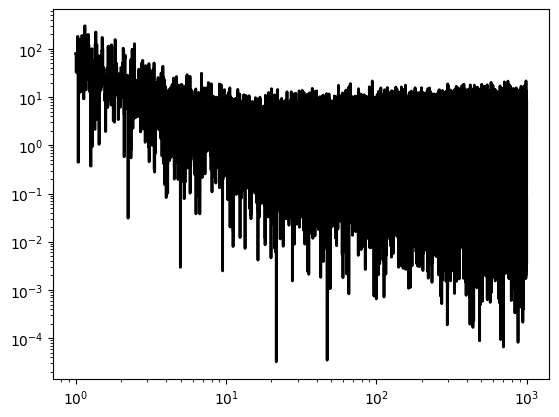

In [70]:
plt.figure()
plt.loglog(ps.freq, ps.power, ds="steps-mid", lw=2, color="black")

In order to fit this, we'll write a convenience function that can take the power spectrum, a model, some starting parameters and just run with it:

In [71]:
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst

def fit_powerspectrum(ps, model, starting_pars, max_post=False, priors=None,
                      fitmethod="L-BFGS-B"):

    if priors:
        lpost = PSDPosterior(ps, model, priors=priors)
    else:
        lpost = PSDLogLikelihood(ps.freq, ps.power, model, m=ps.m)

    parest = PSDParEst(ps, fitmethod=fitmethod, max_post=max_post)
    res = parest.fit(lpost, starting_pars, neg=True)

    return parest, res


Let's see if it works. We've already defined our model above, but to be explicit, let's define it again:

In [72]:
model_to_test = models.PowerLaw1D() + models.Const1D()
model_to_test.x_0_0.fixed = True

Now we just need some starting parameters:

In [73]:
t0 = [80, 1.5, 2.5]

In [74]:
parest, res = fit_powerspectrum(ps, model_to_test, t0)

In [75]:
res.p_opt

array([108.83857491,   2.06954599,   2.0020699 ])

Looks like it worked! Let's plot the result, too:

<Figure size 640x480 with 0 Axes>

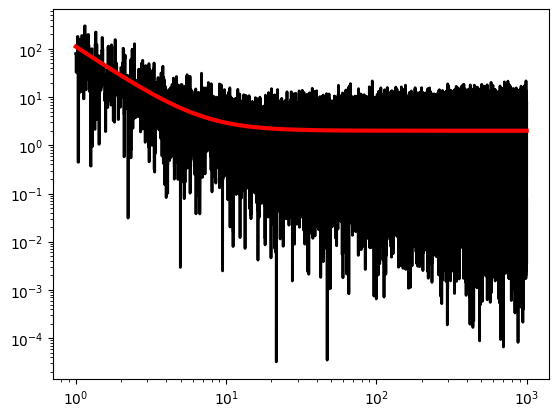

In [76]:
plt.figure()
plt.figure()
plt.loglog(ps.freq, ps.power, ds="steps-mid", lw=2, color="black")
plt.plot(ps.freq, res.mfit, lw=3, color="red")

You can find the function in the `scripts` sub-module:

In [77]:
from stingray.modeling.scripts import fit_powerspectrum

In [78]:
parest, res = fit_powerspectrum(ps, model_to_test, t0)
res.p_opt

array([108.93296388,   2.07033491,   2.0019941 ])

### Fitting Lorentzians

Fitting Lorentzians to power spectra is a routine task for most astronomers working with power spectra, hence there is a function that can produce either Maximum Likelihood or Maximum-A-Posteriori fits of the data.

In [79]:
l = models.Lorentz1D

In [80]:
l.param_names

('amplitude', 'x_0', 'fwhm')

In [81]:
def fit_lorentzians(ps, nlor, starting_pars, fit_whitenoise=True, max_post=False, priors=None,
                    fitmethod="L-BFGS-B"):

    model = models.Lorentz1D()

    if nlor > 1:
        for i in range(nlor-1):
            model += models.Lorentz1D()

    if fit_whitenoise:
        model += models.Const1D()

    parest = PSDParEst(ps, fitmethod=fitmethod, max_post=max_post)
    lpost = PSDPosterior(ps.freq, ps.power, model, priors=priors, m=ps.m)
    res = parest.fit(lpost, starting_pars, neg=True)

    return parest, res

Let's make a dataset so we can test it!

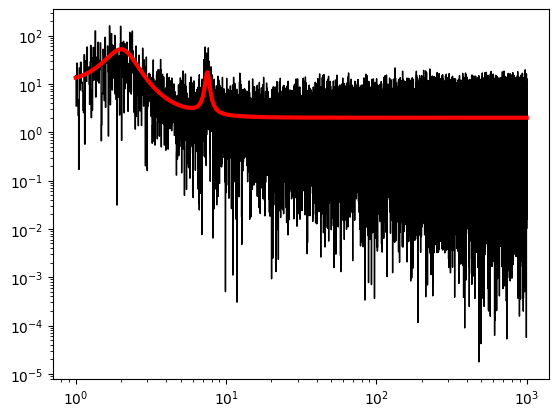

In [82]:
np.random.seed(400)
nlor = 3

x_0_0 = 0.5
x_0_1 = 2.0
x_0_2 = 7.5

amplitude_0 = 150.0
amplitude_1 = 50.0
amplitude_2 = 15.0

fwhm_0 = 0.1
fwhm_1 = 1.0
fwhm_2 = 0.5

whitenoise = 2.0

model = models.Lorentz1D(amplitude_0, x_0_0, fwhm_0) + \
        models.Lorentz1D(amplitude_1, x_0_1, fwhm_1) + \
        models.Lorentz1D(amplitude_2, x_0_2, fwhm_2) + \
        models.Const1D(whitenoise)

p = model(ps.freq)
noise = np.random.exponential(size=len(ps.freq))

power = p*noise

plt.figure()
plt.loglog(ps.freq, power, lw=1, ds="steps-mid", c="black")
plt.loglog(ps.freq, p, lw=3, color="red")

Let's make this into a `Powerspectrum` object:

In [83]:
import copy

In [84]:
ps_new = copy.copy(ps)

In [85]:
ps_new.power = power

So now we can fit this model with our new function, but first, we need to define the starting parameters for our fit. The starting parameters will be `[amplitude, x_0, fwhm]` for each component plus the white noise component at the end:

In [86]:
t0 = [150, 0.4, 0.2, 50, 2.3, 0.6, 20, 8.0, 0.4, 2.1]
parest, res = fit_lorentzians(ps_new, nlor, t0)

Let's look at the output:

In [87]:
res.p_opt

array([1.48884786e+02, 1.00887537e+00, 1.99604427e-06, 4.54760360e+01,
       1.89791712e+00, 1.10971296e+00, 1.01782075e+01, 7.49830286e+00,
       6.60516572e-01, 1.99445911e+00])

Cool, that seems to work! For convenience `PSDParEst` also has a plotting function:

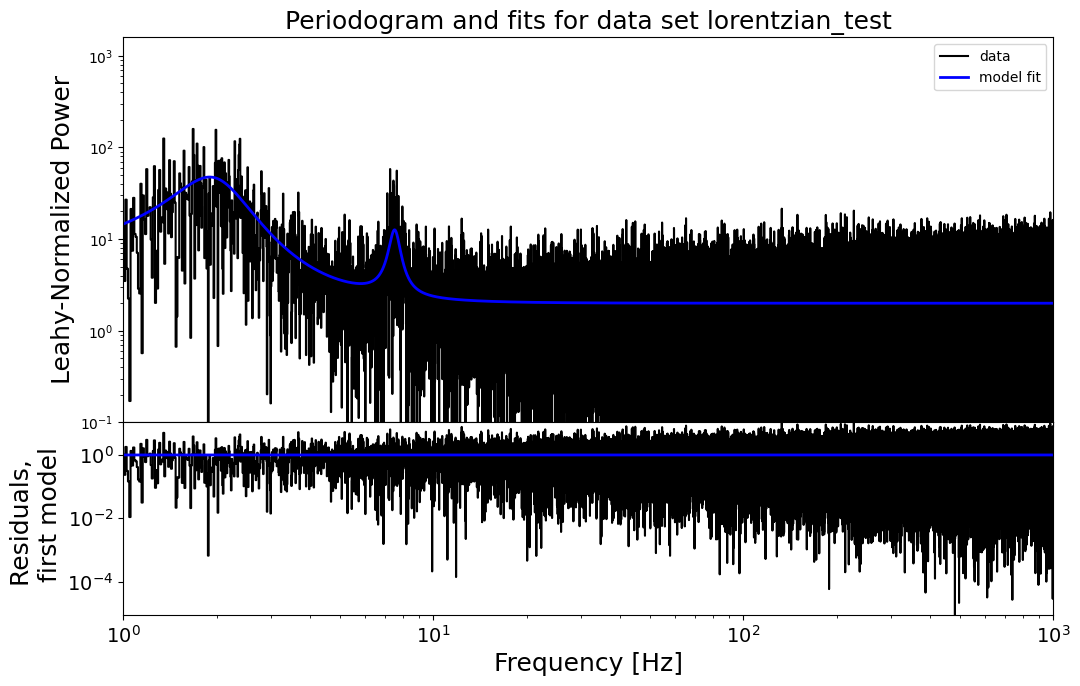

In [88]:
parest.plotfits(res, save_plot=False, namestr="lorentzian_test")

The function exists in the library as well for ease of use:

In [89]:
from stingray.modeling import fit_lorentzians

In [90]:
parest, res = fit_lorentzians(ps_new, nlor, t0)

In [91]:
res.p_opt

array([ 1.47820049e+02, -1.54160483e-01,  3.35702923e-03,  4.52437963e+01,
        1.89770323e+00,  1.11343061e+00,  1.01907081e+01,  7.49801307e+00,
        6.59831901e-01,  1.99444568e+00])